In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta

import os
import sys

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

%run similarities.ipynb

In [2]:
convert={'FIPS': lambda x: str(x)}
main_df = pd.read_csv("../processed_data/combined.csv", converters = convert)
main_df['date'] = main_df['date'].astype(str) + '-20'
main_df['date'] = pd.to_datetime(main_df.date)
main_df["past_week_cases"] = np.mean(main_df[['6_before', '5_before', '4_before', '3_before',
       '2_before', '1_before', '0_before']], axis = 1) 

In [3]:
window_length = 7
window_start = pd.to_datetime("05-25-2020")
window_end = window_start + timedelta(days = window_length)

window_df = main_df[(main_df['date'] >= window_start ) & (main_df['date'] < window_end)].copy()

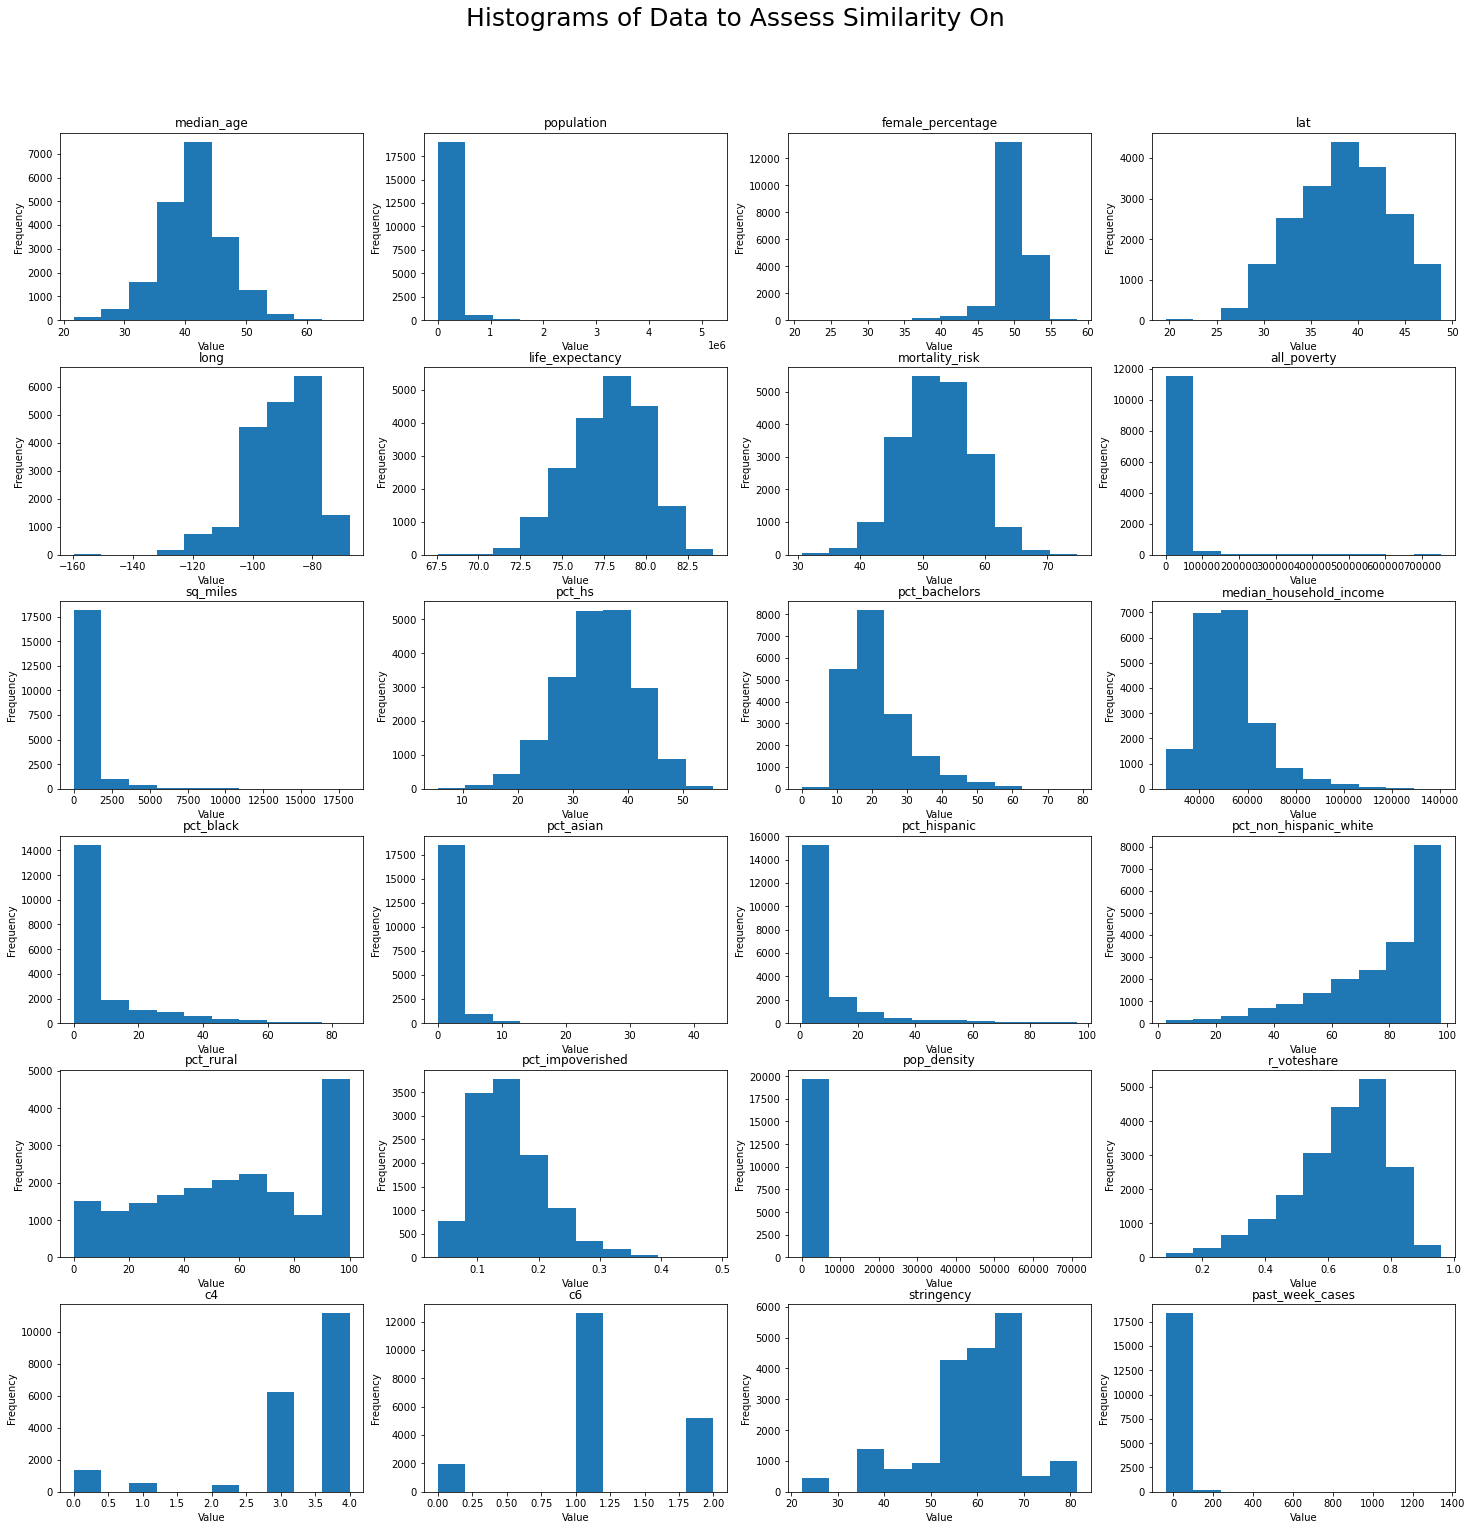

In [4]:
scale_vals = ['median_age', 'population', 'female_percentage', 'lat', 'long',
       'life_expectancy', 'mortality_risk', 'all_poverty', 'sq_miles',
        'pct_hs', 'pct_bachelors', 'median_household_income',
       'pct_black', 'pct_asian', 'pct_hispanic', 'pct_non_hispanic_white',
       'pct_rural', 'pct_impoverished',
       'pop_density', 'r_voteshare', 'c4', 'c6', 'stringency','past_week_cases']

fig, axes = plt.subplots(6,4,figsize = (25,25))

for i, ax in enumerate(axes.ravel()):
    ax.hist(window_df[scale_vals[i]].dropna())
    ax.set_title(scale_vals[i])
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Value")

fig.subplots_adjust(hspace = 0.25)
fig.suptitle("Histograms of Data to Assess Similarity On", fontsize = "25", y = 0.95)

plt.show()

In [5]:
scaler = MinMaxScaler().fit(window_df[scale_vals])
window_df[scale_vals] = scaler.transform(window_df[scale_vals])

In [6]:
yes_df = window_df[window_df["protest_size"] != -1].copy()
no_df = window_df[window_df["protest_size"] == -1].copy()

yes_df.drop(["protest_size"], axis = 1, inplace = True)
yes_df.reset_index(inplace = True, drop = True)
no_df.drop(["protest_size"], axis = 1, inplace = True)
no_df.reset_index(inplace = True, drop = True)

comparables = ['median_age', 'population', 'female_percentage', 'lat', 'long',
       'life_expectancy', 'mortality_risk', 'all_poverty', 'sq_miles',
        'pct_hs', 'pct_bachelors', 'median_household_income',
       'pct_black', 'pct_asian', 'pct_hispanic', 'pct_non_hispanic_white',
       'pct_rural', 'pct_impoverished',
       'pop_density', 'r_voteshare', 'c4', 'c6', 'stringency','past_week_cases']

search_df = yes_df[comparables].copy()
compare_df = no_df[comparables].copy()

In [7]:
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress
    
    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.
    
    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::
    
        for i in range(n_iterations):
            progressbar(i, n_iterations)
            
    .. source:
    
        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

In [11]:
# nearest_idx = {}
# checks = ["pop_density", "past_week_cases", "r_voteshare"]
# check_vals = [0.3, 0.3, 0.3]

# closest = {}
# # test = 0
# for idx, row in search_df.iterrows():
# #     if test >= 2:
# #         break
#     closest[idx] = find_approx_closest(compare_df[no_df.date == yes_df.date[idx]], row, checks, check_vals, n = 20, num_weights = 20)
#     progressbar(idx, search_df.shape[0])
# #     test += 1
    
# np.save("../processed_data/closest_counties.npy", closest)

In [9]:
closest = np.load("../processed_data/closest_counties.npy", allow_pickle = "TRUE").item()

In [10]:
closest_counties = pd.DataFrame(closest).transpose().set_index([yes_df.fips, yes_df.date])

counts = closest_counties.applymap(len)
num_counties_under_20 = sum((counts < 20).any(axis = 1))
num_counties_0 = sum((counts < 1).any(axis = 1))
print(f"Only {num_counties_under_20} protest counties had fewer than 20 similar counties for any distance metrics; of these, only {num_counties_0} had no similar counties for any metrics.")

Only 15 protest counties had fewer than 20 similar counties for any distance metrics; of these, only 7 had no similar counties for any metrics.


In [14]:
treatment_outcome = "past_week_cases"
time_frame = 14

actual = closest_counties.iloc[:, 0].copy()
counterfactual = closest_counties.copy()

for ind, row in closest_counties.iterrows():
    check_date = ind[1] + timedelta(days = time_frame)
    actual[ind] = main_df[(main_df.fips == ind[0]) & (main_df.date == check_date)][treatment_outcome].values.item()
    
    for col in closest_counties.columns:
        check_fips = [no_df.loc[i].fips for i in closest_counties.loc[ind, col]]
        counterfactual.loc[ind, col] = np.nanmean(main_df[(main_df.fips.isin(check_fips)) & (main_df.date == check_date)][treatment_outcome].values)
    
diff = -1 * counterfactual.subtract(actual, axis = "rows")

<ipython-input-14-b72653f8d448>:13: RuntimeWarning: Mean of empty slice
  counterfactual.loc[ind, col] = np.nanmean(main_df[(main_df.fips.isin(check_fips)) & (main_df.date == check_date)][treatment_outcome].values)


In [70]:
treatment_ueuc = diff.euc_unweighted

treatment_ueuc_avg = np.nanmean(treatment_ueuc)
treatment_ueuc_sorted = treatment_ueuc.dropna().values
treatment_ueuc_sorted.sort()
treatment_ueuc_ci_l, treatment_ueuc_ci_r = (np.percentile(treatment_ueuc_sorted, 2.5), np.percentile(treatment_ueuc_sorted, 97.5))
treatment_ueuc_50ci_l, treatment_ueuc_50ci_r = (np.percentile(treatment_ueuc_sorted, 25), np.percentile(treatment_ueuc_sorted, 75))

print(f"Using unweighted Euclidean distance, the average treatment effect was {treatment_ueuc_avg:.4f}, with a 95% confidence interval of ({treatment_ueuc_ci_l:.4f}, {treatment_ueuc_ci_r:.4f}) and an a 80% confidence interval of ({treatment_ueuc_50ci_l:.4f}, {treatment_ueuc_50ci_r:.4f})")

Using unweighted Euclidean distance, the average treatment effect was 16.3480, with a 95% confidence interval of (-15.1780, 137.8204) and an a 80% confidence interval of (-1.9000, 15.1018)


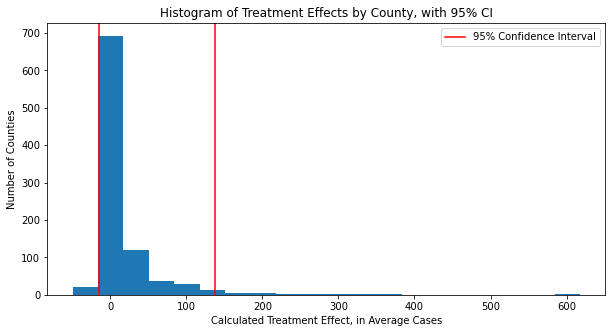

In [72]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))

ax.hist(treatment_ueuc, 20)
ax.axvline(treatment_ueuc_ci_l, c = "r")
ax.axvline(treatment_ueuc_ci_r, c = "r")
ax.set_xlabel("Calculated Treatment Effect, in Average Cases")
ax.set_ylabel("Number of Counties")
ax.set_title("Histogram of Treatment Effects by County, with 95% CI")
ax.legend(["95% Confidence Interval"])

fig.show()

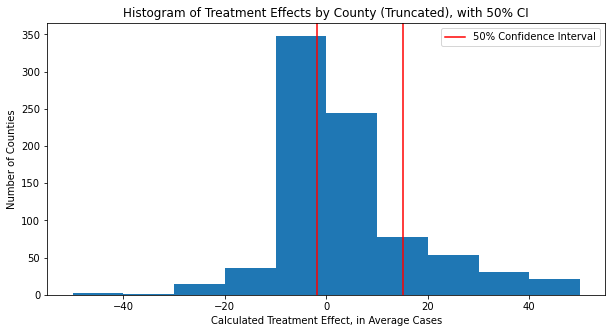

In [76]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))

ax.hist(treatment_ueuc, range = (-50, 50), bins = 10)
ax.axvline(treatment_ueuc_50ci_l, c = "r")
ax.axvline(treatment_ueuc_50ci_r, c = "r")
ax.set_xlabel("Calculated Treatment Effect, in Average Cases")
ax.set_ylabel("Number of Counties")
ax.set_title("Histogram of Treatment Effects by County (Truncated), with 50% CI")
ax.legend(["50% Confidence Interval"])

fig.show()

In [38]:
treatment_euc = diff.drop(["cos", "euc_unweighted"], axis = 1).dropna(axis = 0)
num_containing_0 = sum((np.percentile(treatment_euc, 40, axis = 0) < 0) & (np.percentile(treatment_euc, 60, axis = 0) > 0))

print(f"Using randomly weighted Euclidean distance, {num_containing_0} of 20 weightings resulted in a 95% CI containing 0.")

Using randomly weighted Euclidean distance, 20 of 20 weightings resulted in a 95% CI containing 0.


In [203]:
treatment_cos = diff.cos

treatment_cos_avg = np.nanmean(treatment_cos)
treatment_cos_sorted = treatment_cos.dropna().values
treatment_cos_sorted.sort()
treatment_cos_ci_l, treatment_cos_ci_r = (np.percentile(treatment_cos_sorted, 2.5), np.percentile(treatment_cos_sorted, 97.5))

print(f"Using cosine distance, the average treatment effect was {treatment_cos_avg:.4f}, with a 95% confidence interval of ({treatment_cos_ci_l:.4f}, {treatment_cos_ci_r:.4f})")

Using cosine distances, the average treatment effect was 25.4287, with a 95% confidence interval of (-20.9321, 201.1502)
